###Importing the required library

In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.7 MB/s eta 0:00:00


In [3]:
## Handling data
import pandas as pd
import numpy as np

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
## Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

## Statistic
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

## Metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, log_loss
from sklearn.metrics import cohen_kappa_score, average_precision_score, precision_recall_curve, roc_curve

import shap

###Load the data using Pandas

In [9]:
# Load the dataset
data = pd.read_csv('loan_approval_dataset.csv')

In [10]:
# Remove leading and trailing whitespaces from column names
data.columns = data.columns.str.strip()

In [11]:
data.shape

(4269, 13)

In [12]:
# View the first few rows of the datase
data.head()

loan_id  no_of_dependents      education self_employed  income_annum  \
0        1                 2       Graduate            No       9600000   
1        2                 0   Not Graduate           Yes       4100000   
2        3                 3       Graduate            No       9100000   
3        4                 3       Graduate            No       8200000   
4        5                 5   Not Graduate           Yes       9800000   

   loan_amount  loan_term  cibil_score  residential_assets_value  \
0     29900000         12          778                   2400000   
1     12200000          8          417                   2700000   
2     29700000         20          506                   7100000   
3     30700000          8          467                  18200000   
4     24200000         20          382                  12400000   

   commercial_assets_value  luxury_assets_value  bank_asset_value loan_status  
0                 17600000             22700000           8000000    Approved  
1                  2200000              8800000           3300000    Rejected  
2                  4500000             33300000          12800000    Rejected  
3                  3300000             23300000           7900000    Rejected  
4                  8200000             29400000           5000000    Rejected

In [13]:
#drop the loan id the column
data.drop(columns=['loan_id'], inplace=True)

In [14]:
#Function to interprete CIBIL score to factors

def categorize_cibil(score):
    if score >= 300 and score <= 549:
        return "Poor"
    elif score >= 550 and score <= 649:
        return "Fair"
    elif score >= 650 and score <= 749:
        return "Good"
    elif score >= 750 and score <= 799:
        return "VeryGood"
    else:
        return "Excellent"

# Apply the function to create a new column 'CIBIL_Status'
data['CIBIL_Status'] = data['cibil_score'].apply(categorize_cibil)

# Display the updated dataset
print(data[['cibil_score', 'CIBIL_Status']].head())


   cibil_score CIBIL_Status
0          778     VeryGood
1          417         Poor
2          506         Poor
3          467         Poor
4          382         Poor


###Exploratory Data Analysis

In [15]:
data.columns

Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'loan_status', 'CIBIL_Status'],
      dtype='object')

In [16]:
# Checking for missing data
data.isnull().mean()

no_of_dependents            0.0
education                   0.0
self_employed               0.0
income_annum                0.0
loan_amount                 0.0
loan_term                   0.0
cibil_score                 0.0
residential_assets_value    0.0
commercial_assets_value     0.0
luxury_assets_value         0.0
bank_asset_value            0.0
loan_status                 0.0
CIBIL_Status                0.0
dtype: float64

In [17]:
data.describe()

no_of_dependents  income_annum   loan_amount    loan_term  cibil_score  \
count       4269.000000  4.269000e+03  4.269000e+03  4269.000000  4269.000000   
mean           2.498712  5.059124e+06  1.513345e+07    10.900445   599.936051   
std            1.695910  2.806840e+06  9.043363e+06     5.709187   172.430401   
min            0.000000  2.000000e+05  3.000000e+05     2.000000   300.000000   
25%            1.000000  2.700000e+06  7.700000e+06     6.000000   453.000000   
50%            3.000000  5.100000e+06  1.450000e+07    10.000000   600.000000   
75%            4.000000  7.500000e+06  2.150000e+07    16.000000   748.000000   
max            5.000000  9.900000e+06  3.950000e+07    20.000000   900.000000   

       residential_assets_value  commercial_assets_value  luxury_assets_value  \
count              4.269000e+03             4.269000e+03         4.269000e+03   
mean               7.472617e+06             4.973155e+06         1.512631e+07   
std                6.503637e+06             4.388966e+06         9.103754e+06   
min               -1.000000e+05             0.000000e+00         3.000000e+05   
25%                2.200000e+06             1.300000e+06         7.500000e+06   
50%                5.600000e+06             3.700000e+06         1.460000e+07   
75%                1.130000e+07             7.600000e+06         2.170000e+07   
max                2.910000e+07             1.940000e+07         3.920000e+07   

       bank_asset_value  
count      4.269000e+03  
mean       4.976692e+06  
std        3.250185e+06  
min        0.000000e+00  
25%        2.300000e+06  
50%        4.600000e+06  
75%        7.100000e+06  
max        1.470000e+07

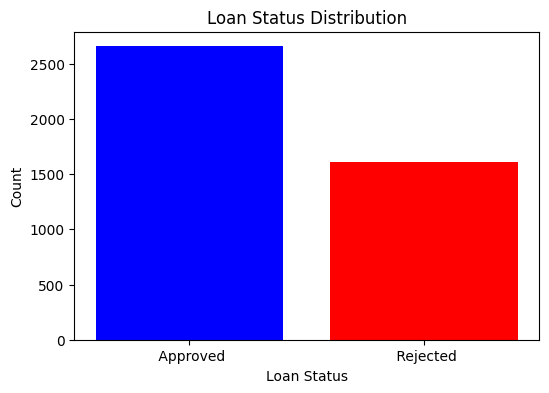

In [18]:
loan_status_counts = data['loan_status'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(loan_status_counts.index, loan_status_counts.values, color=['blue', 'red'])
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

####Univariate Analysis

In [19]:
## selecting the numeric and categorical variables to plot.
categorical_graph = data.select_dtypes(include=['object','category']).columns.to_list()
numerical_graph = data.select_dtypes(include=['int','float']).columns.to_list()

print('=='*30)
print('Variables of categorical origin and number of unique values')
print('=='*30)
for category in categorical_graph:
    print('*',category,'-->',data[category].nunique())

print('--'*30)
print('=='*30)
print('Numeric Source Variables')
print('=='*30)
for numerica in numerical_graph:
  print('*',numerica)

Variables of categorical origin and number of unique values
* education --> 2
* self_employed --> 2
* loan_status --> 2
* CIBIL_Status --> 5
------------------------------------------------------------
Numeric Source Variables
* no_of_dependents
* income_annum
* loan_amount
* loan_term
* cibil_score
* residential_assets_value
* commercial_assets_value
* luxury_assets_value
* bank_asset_value


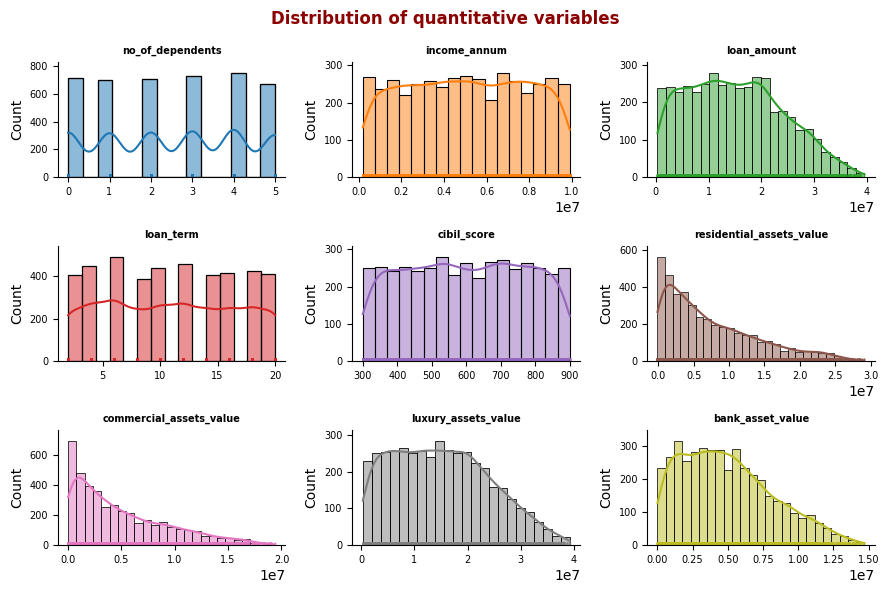

In [20]:
fig,ax = plt.subplots(3,3,figsize=(9,6))
ax = ax.flat
for i,col in enumerate(numerical_graph):
  sns.histplot(data,
               x = col,
               stat = 'count',
               kde=True,
               color    = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
               line_kws = {'linewidth':1.5},
               ax = ax[i])
  sns.rugplot(data,
              x = col,
              color    = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
              alpha = 1.0,
              ax = ax[i])
  ax[i].spines['top'].set_visible(False)
  ax[i].spines['right'].set_visible(False)
  ax[i].tick_params(labelsize=7)
  ax[i].set_title(col, fontsize = 7, fontweight = 'bold')
  ax[i].set_xlabel('')
fig.suptitle('Distribution of quantitative variables',fontsize=12, fontweight='bold',color='darkred')
fig.subplots_adjust(top=0.9)
fig.tight_layout()
fig.show()

In [21]:
## Function to check if data is normally distributed.
def shapiro_test(col:str):
  stat,p_value = shapiro(data[col])
  if p_value < 0.05:
    return f'{col} is not  Normally distributed'
  else:
    return f'{col} is Normally distributed'

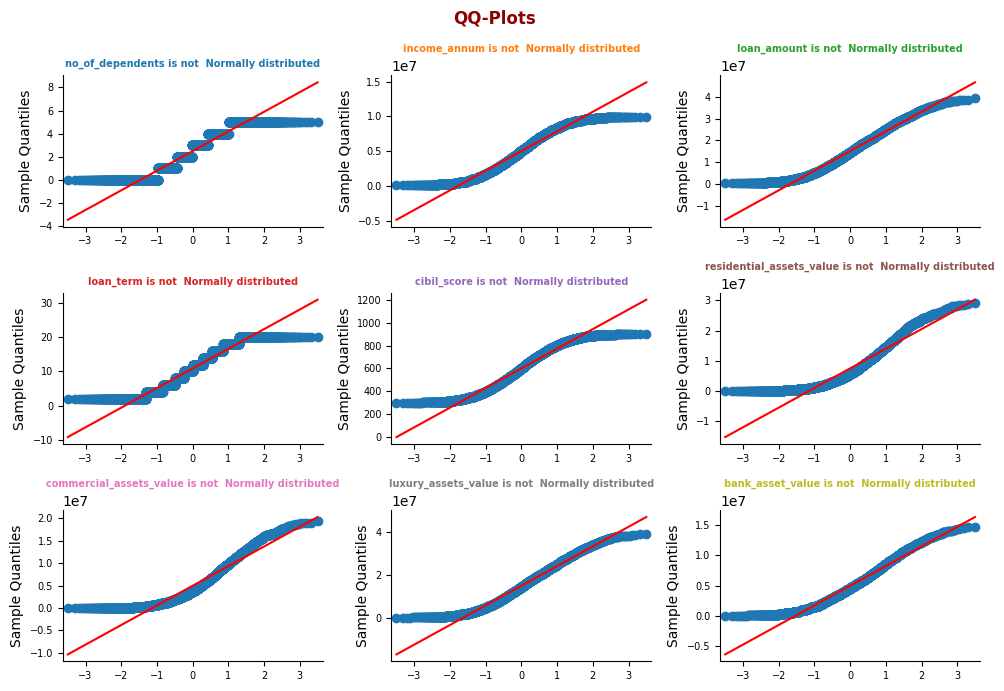

In [22]:
## create QQ-Plot graphs.
fig,ax = plt.subplots(3,3,figsize=(10,7))
ax = ax.flat
for i,col in enumerate(numerical_graph):
  qqplot(data[col], line = 's', ax = ax[i])
  ax[i].spines['top'].set_visible(False)
  ax[i].spines['right'].set_visible(False)
  ax[i].tick_params(labelsize=7)
  ax[i].set_title(shapiro_test(col), fontsize = 7, fontweight = 'bold', color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"])
  ax[i].set_xlabel('')
fig.suptitle('QQ-Plots',fontsize=12, fontweight='bold',color='darkred')
fig.subplots_adjust(top=0.9)
fig.tight_layout()
fig.show()

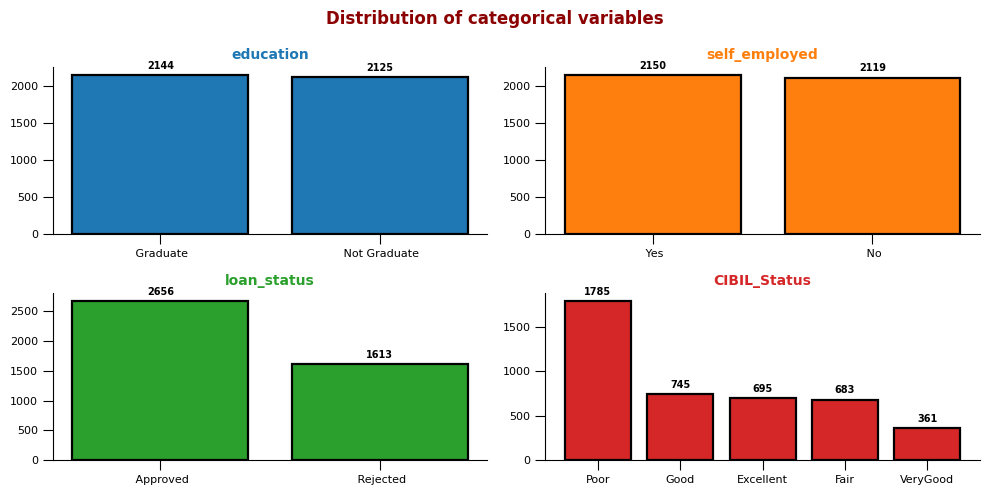

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
ax = ax.flat

for i,column in enumerate(categorical_graph):
  df1 = data[column].value_counts().to_frame()
  rects1 = ax[i].bar(df1.index, df1.iloc[:,0], linewidth = 1.6, edgecolor = 'black',color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"])
  ax[i].set_title(column,fontsize=10,fontweight='bold',color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"])
  ax[i].tick_params(labelsize=8, size=7, labelcolor = 'black')
  ax[i].spines['top'].set_visible(False)
  ax[i].spines['bottom'].set_visible(True)
  ax[i].spines['right'].set_visible(False)
  def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax[i].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2 , height-0.005),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', size = 7, weight = 'bold')
  autolabel(rects1)

fig.suptitle('Distribution of categorical variables',fontsize=12,fontweight='bold',color='darkred')
fig.subplots_adjust(top=0.9)
fig.tight_layout()
fig.show()

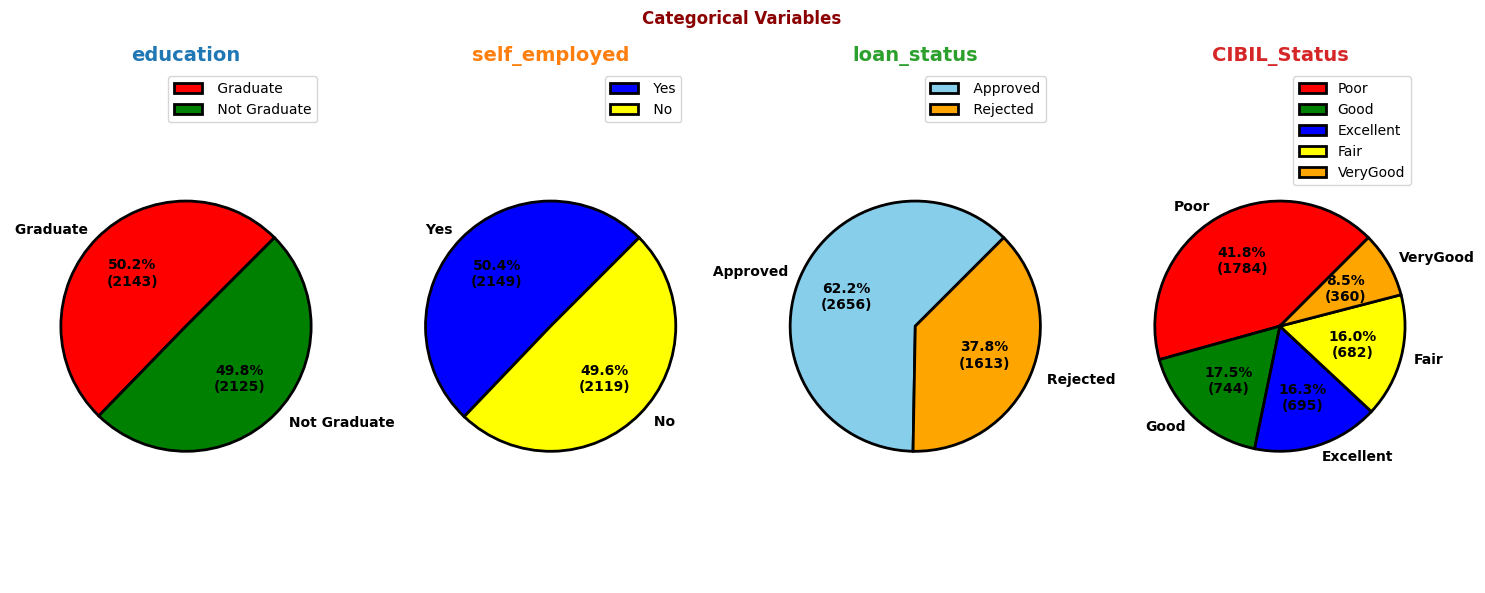

In [24]:
fig,ax = plt.subplots(1,4,figsize=(15,6))
colors = [['red','green'],['blue','yellow'],['skyblue','orange'],['red','green','blue','yellow','orange']]
for i,col in enumerate(categorical_graph):
  def func(pct, allvalues):

      absolute = int(pct/100.*np.sum(allvalues))
      return "{:.1f}%\n({:d})".format(pct, absolute)

  counts = data[col].value_counts()

  labels = counts.index.tolist()
  values = counts.values.tolist()

  ax[i].pie(x = values, labels = labels, autopct = lambda pct: func(pct,counts.values),
        startangle=45, colors = colors[i] ,wedgeprops={'linewidth':2,'edgecolor':'black'},
        textprops = {'color':'black', 'weight':'bold','fontsize':10})
  ax[i].set_title(col, fontsize = 14, fontweight = 'bold', color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"])
  ax[i].axis('equal')
  ax[i].legend()

fig.suptitle('Categorical Variables',fontsize=12,fontweight='bold',color='darkred')
fig.subplots_adjust(top=0.9)
fig.tight_layout()
fig.show()

####Bivariate Analysis

Text(0.5, 1.0, 'Self Employed by Education Level')

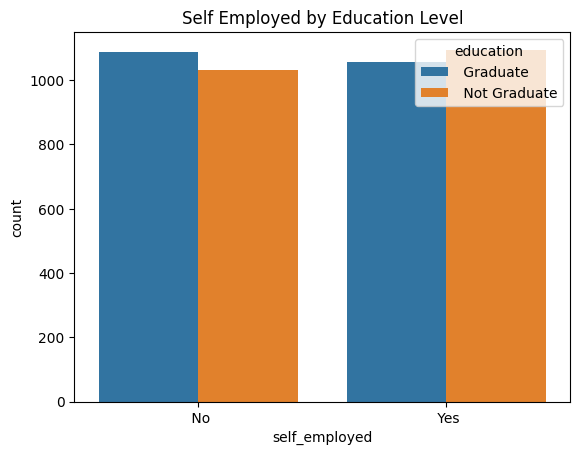

In [25]:
sns.countplot(x='self_employed', data = data, hue = 'education').set_title('Self Employed by Education Level')

<Figure size 800x600 with 0 Axes>

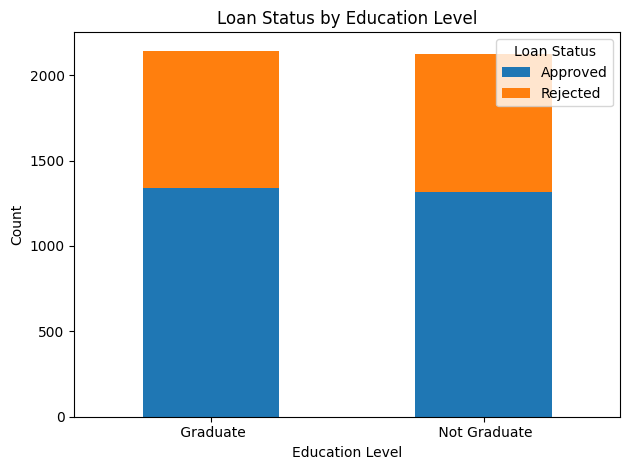

In [26]:
### Loan Status by Education Level
if 'education' in data.columns and 'loan_status' in data.columns:
    # Group the data by 'education' and 'loan_status' and count the occurrences
    education_loan_status_counts = data.groupby(['education', 'loan_status']).size().unstack()

    # Plot the bar chart
    plt.figure(figsize=(8, 6))
    education_loan_status_counts.plot(kind='bar', stacked=True)
    plt.title('Loan Status by Education Level')
    plt.xlabel('Education Level')
    plt.ylabel('Count')
    plt.legend(title='Loan Status', loc='upper right', labels=['Approved', 'Rejected'])
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

<Axes: xlabel='no_of_dependents', ylabel='count'>

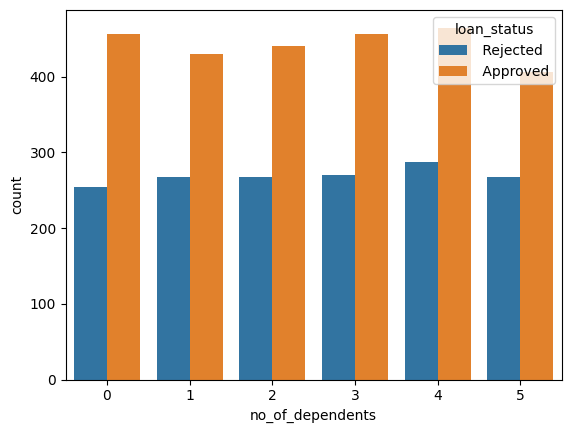

In [27]:
sns.countplot(x = 'no_of_dependents', data = data, hue = 'loan_status')

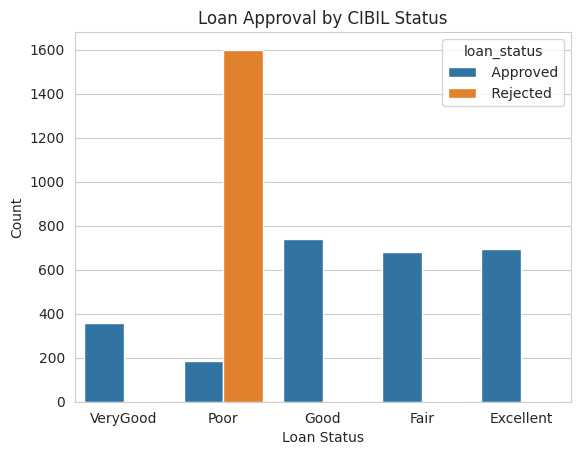

In [28]:
# Set the style
sns.set_style("whitegrid")

# Create a count plot
sns.countplot(data=data, x='CIBIL_Status', hue='loan_status')

# Add title and labels
plt.title('Loan Approval by CIBIL Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')

# Show the plot
plt.show()

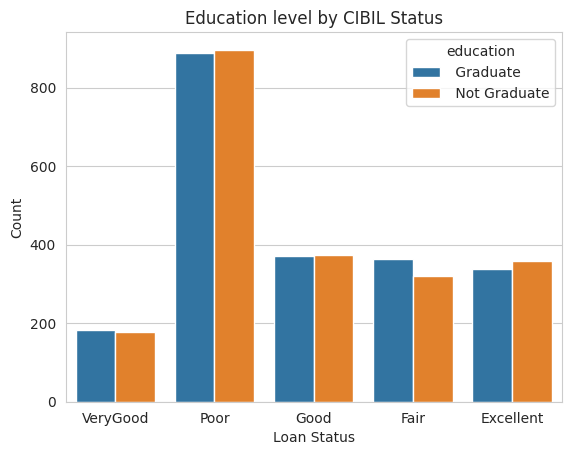

In [29]:
# Set the style
sns.set_style("whitegrid")

# Create a count plot
sns.countplot(data=data, x='CIBIL_Status', hue='education')

# Add title and labels
plt.title('Education level by CIBIL Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')

# Show the plot
plt.show()

###Multivariate PLot

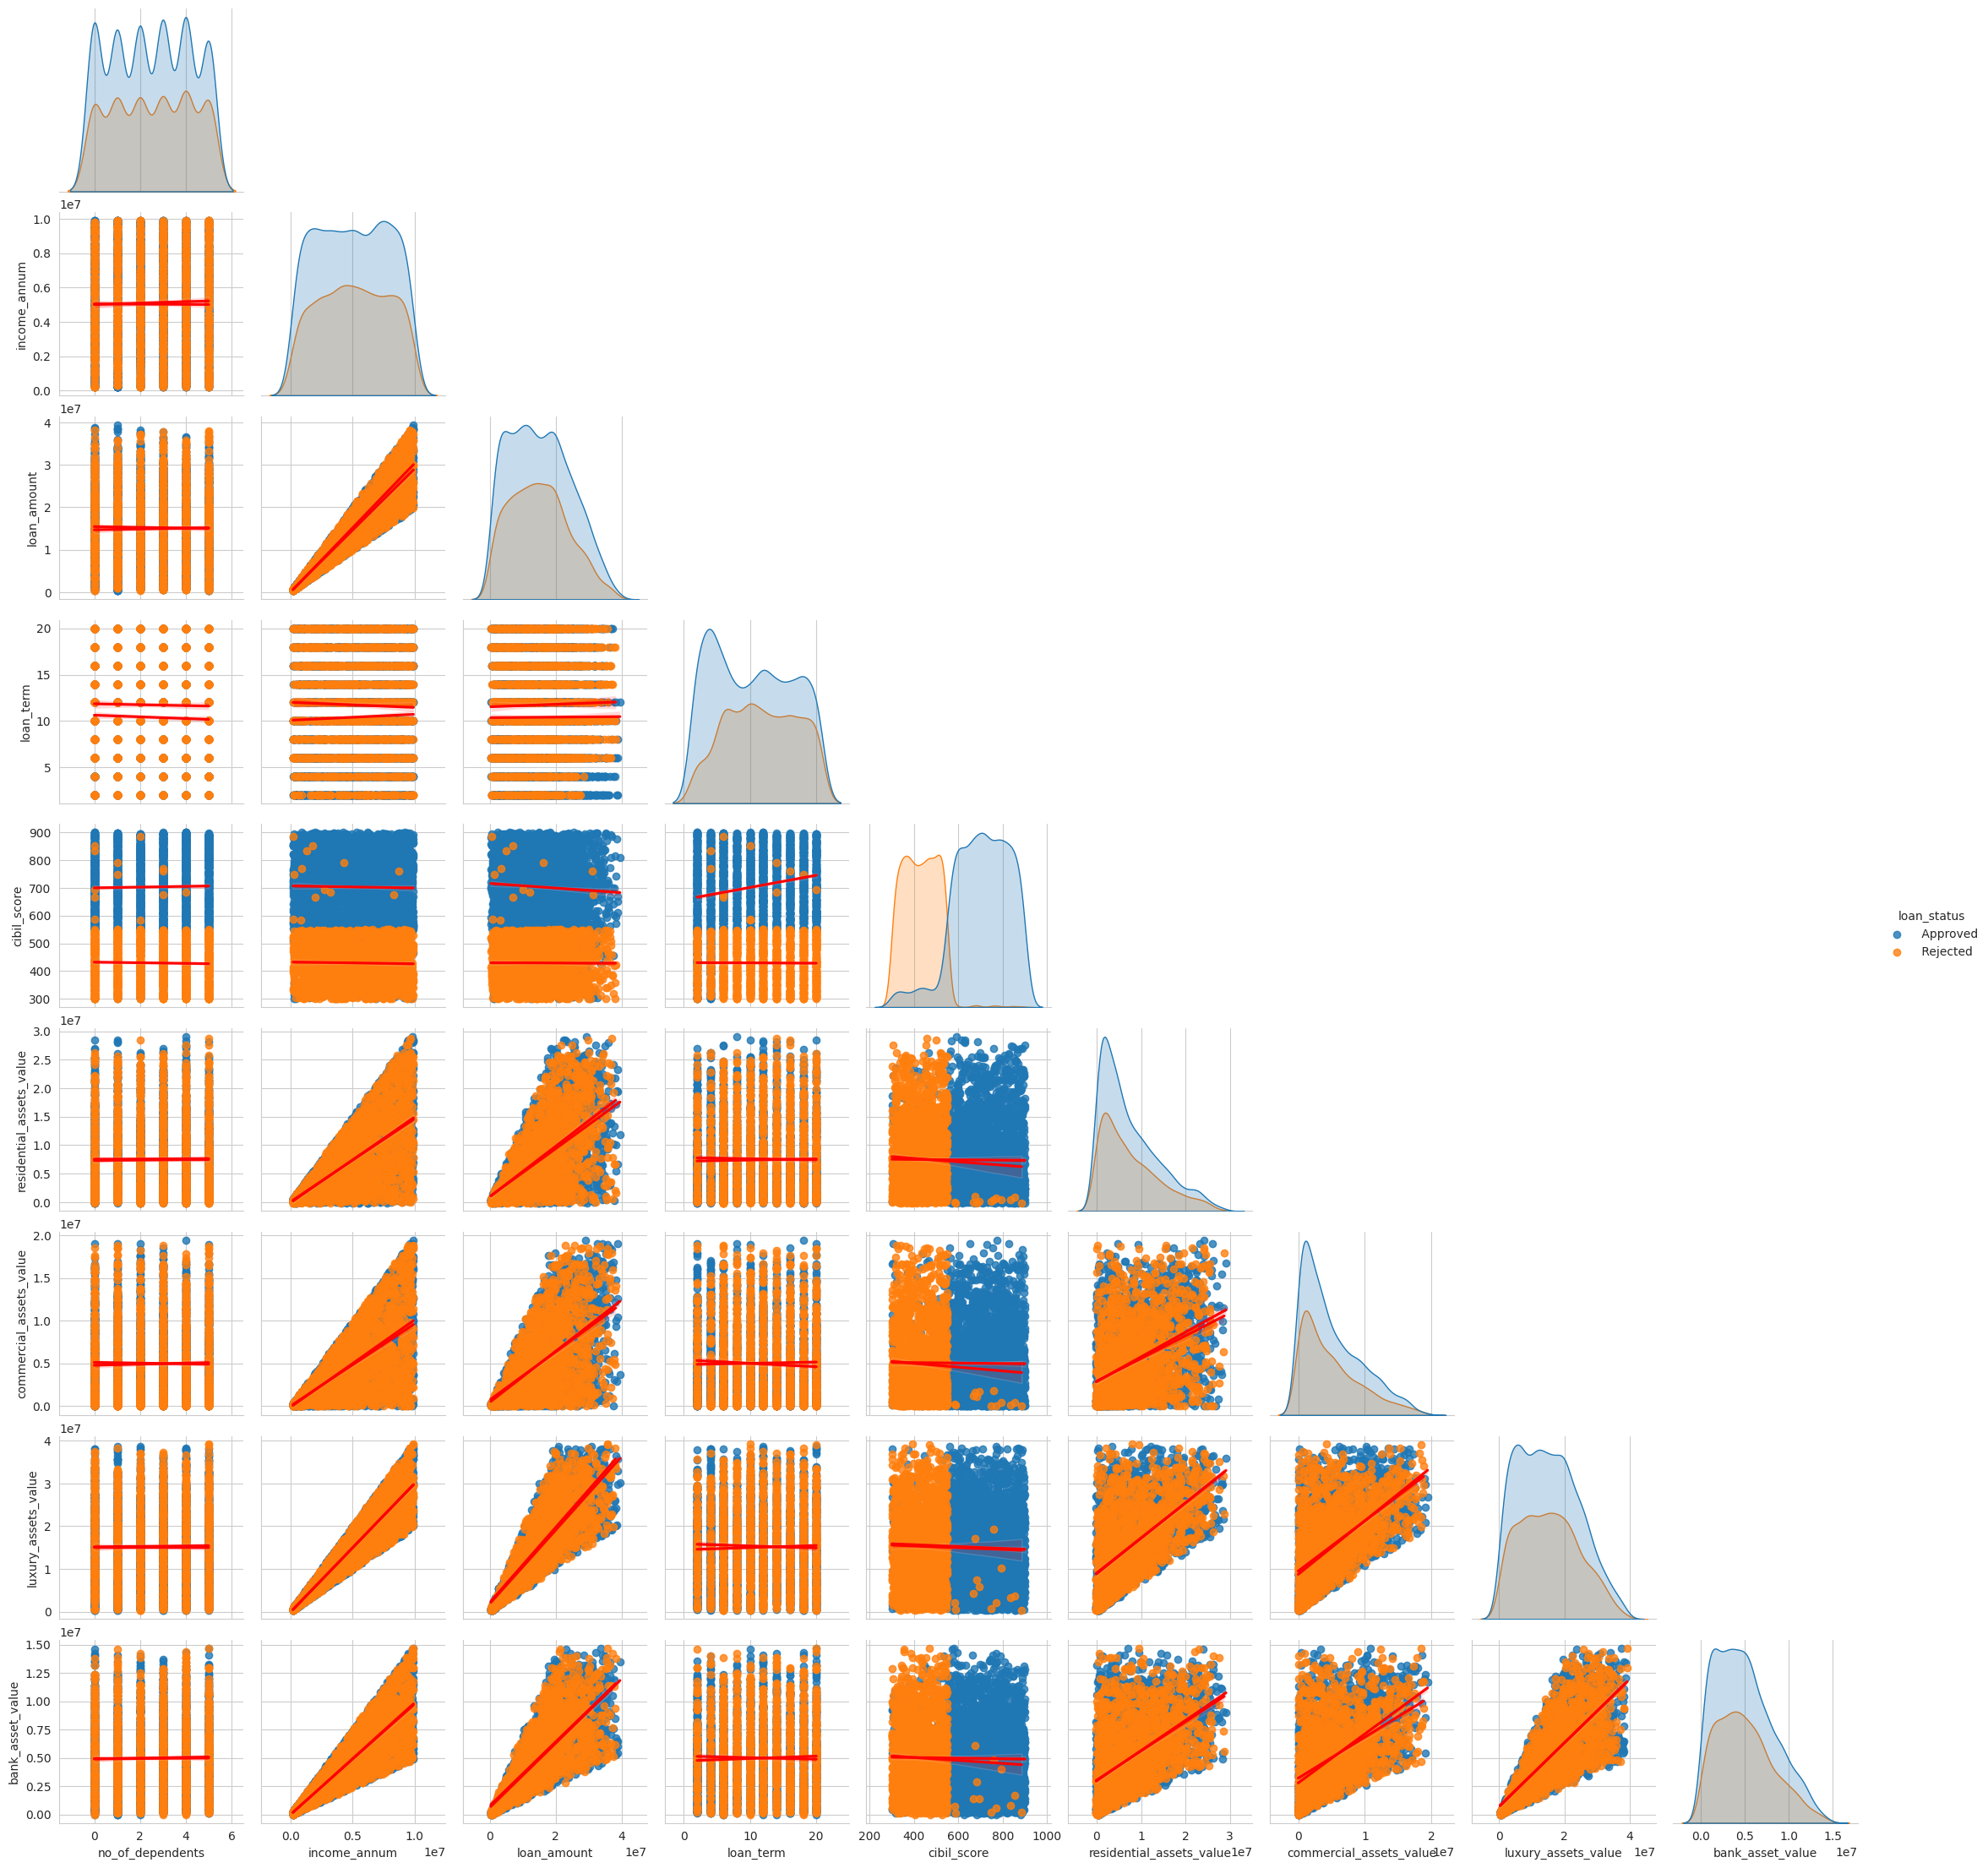

In [30]:
plot_multivariate = sns.pairplot(data,
                                 corner=True,
                                 diag_kind='kde',
                                 hue = 'loan_status',
                                 kind = 'reg',
                                 plot_kws = {'line_kws':{'color':'red'}},
                                 diag_kws = {'color':'green'})
plot_multivariate.fig.show()

###Preprocessing

In [31]:
data=data.drop('cibil_score',axis = 1)
data.head()

no_of_dependents      education self_employed  income_annum  loan_amount  \
0                 2       Graduate            No       9600000     29900000   
1                 0   Not Graduate           Yes       4100000     12200000   
2                 3       Graduate            No       9100000     29700000   
3                 3       Graduate            No       8200000     30700000   
4                 5   Not Graduate           Yes       9800000     24200000   

   loan_term  residential_assets_value  commercial_assets_value  \
0         12                   2400000                 17600000   
1          8                   2700000                  2200000   
2         20                   7100000                  4500000   
3          8                  18200000                  3300000   
4         20                  12400000                  8200000   

   luxury_assets_value  bank_asset_value loan_status CIBIL_Status  
0             22700000           8000000    Approved     VeryGood  
1              8800000           3300000    Rejected         Poor  
2             33300000          12800000    Rejected         Poor  
3             23300000           7900000    Rejected         Poor  
4             29400000           5000000    Rejected         Poor

In [32]:
## remove the whitespace on either side of each value of the 'loan_status' variable.
data['loan_status'] = data['loan_status'].str.strip()

In [33]:
## map the values of the target variable to convert to numeric values.
## 1 : Approved
## 0 : Rejected

map = {'Approved':1, 'Rejected':0}

data['loan_status'] = data['loan_status'].map(map)

In [34]:
data.head()

no_of_dependents      education self_employed  income_annum  loan_amount  \
0                 2       Graduate            No       9600000     29900000   
1                 0   Not Graduate           Yes       4100000     12200000   
2                 3       Graduate            No       9100000     29700000   
3                 3       Graduate            No       8200000     30700000   
4                 5   Not Graduate           Yes       9800000     24200000   

   loan_term  residential_assets_value  commercial_assets_value  \
0         12                   2400000                 17600000   
1          8                   2700000                  2200000   
2         20                   7100000                  4500000   
3          8                  18200000                  3300000   
4         20                  12400000                  8200000   

   luxury_assets_value  bank_asset_value  loan_status CIBIL_Status  
0             22700000           8000000            1     VeryGood  
1              8800000           3300000            0         Poor  
2             33300000          12800000            0         Poor  
3             23300000           7900000            0         Poor  
4             29400000           5000000            0         Poor

In [35]:
## divide into predictor variables and response variable.

y = data['loan_status']
X = data.drop("loan_status",axis = 1)

## divide into training and test data.
X_train, X_test, y_train, y_test = train_test_split(X,
                                       y,
                                       test_size=0.2,
                                       random_state = 42,
                                       shuffle = True,
                                       stratify = y)
print('=='*15)
print('Size of our training set:')
print('=='*15)
print(f'X_train ==> {X_train.shape}')
print(f'y_train ==> {y_train.shape}\n')
print('=='*15)
print('Size of our testing set:')
print('=='*15)
print(f'X_test ==> {X_test.shape}')
print(f'y_test ==> {y_test.shape}')

Size of our training set:
X_train ==> (3415, 11)
y_train ==> (3415,)

Size of our testing set:
X_test ==> (854, 11)
y_test ==> (854,)


In [36]:
### select the categorical and numeric variables for preprocessing.

# Qualitative variables.
categorical_cols = X_train.select_dtypes(include=['object','category']).columns.to_list()
# Quantitative variables.
numerical_cols = X_train.select_dtypes(include=['int','float']).columns.to_list()

####Label Encoding

In [37]:
## define my preprocessor.
# - OneHotEncoder encoding for qualitative variables.
# - Standardization for quantitative variables.
preprocessor = ColumnTransformer([('ohe',OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
                                    categorical_cols),
                                   ('scaler',StandardScaler(),numerical_cols)],
                                  remainder = 'passthrough',
                                  verbose_feature_names_out=False).set_output(transform='pandas')

## fit and transform training data.
X_train_prep = preprocessor.fit_transform(X_train)

## transform test set.
X_test_prep = preprocessor.transform(X_test)

## show the size of data sets.
print(f'Training Set Size: {X_train_prep.shape}')
print(f'Testing Set Size: {X_test_prep.shape}')

Training Set Size: (3415, 17)
Testing Set Size: (854, 17)


In [38]:
## transform data that is in 'pandas' format to type 'array'.
X_train_prep_array = X_train_prep.to_numpy(dtype = 'float32')
X_test_prep_array = X_test_prep.to_numpy(dtype = 'float32')
y_train_array = y_train.to_numpy(dtype = 'float32')
y_test_array = y_test.to_numpy(dtype = 'float32')

###Evaluation Metrics

In [39]:
## Specificity score
def specificity_score(y_true:np.ndarray, y_pred:np.ndarray):
  """
  Function to calculate the specificity score.

  Args:

    - y_true(array): true value.
    - y_pred(array): predicted value.

  Return:

    -specificity_score(float)
  """
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  specificity = tn/(tn+fp)
  return specificity

In [40]:
from typing import Dict
def metrics_classification (y_true:np.ndarray,
                            y_pred:np.ndarray,
                            y_probs_positive:np.ndarray) -> Dict[str,float]:
  """
  Function to calculate the following Classification Metrics.

  - accuracy
  - f1_score
  - precision
  - recall
  - auc
  - specificity
  - log_loss
  - cohen_kappa
  - gini

  Args:
  - y_true(array): true value.
  - y_pred(array): predicted value.
  - y_probs_positive(array): positive class value.

  Return:
  - Metrics Classification(dict)
  """
  accuracy = round(accuracy_score(y_true, y_pred),3)
  f1 = round(f1_score(y_true, y_pred),3)
  precision = round(precision_score(y_true, y_pred),3)
  recall = round(recall_score(y_true, y_pred),3)
  auc = round(roc_auc_score(y_true, y_probs_positive),3)
  specificity = round(specificity_score(y_true, y_pred),3)
  logloss = round(log_loss(y_true, y_probs_positive),3)
  cohen_kappa = round(cohen_kappa_score(y_true, y_pred),3)
  gini = round(2 * auc -1,2)

  my_metrics = {'accuracy':accuracy,
                'f1_score':f1,
                'precision':precision,
                'recall':recall,
                'specificity':specificity,
                'auc':auc,
                'log_loss':logloss,
                'cohen_kappa':cohen_kappa,
                'gini':gini}
  return my_metrics

In [41]:
## Metrics plots
def metrics_plot(metrics_train:dict, metrics_test:dict, metrics:list)->None:
    """
    Function to plot the selected metrics.

    Args:

      - metrics_train(dict): training set metrics.
      - metrics_test(dict): testing set metrics.
      - metrics(list): list of metrics to plot.

    Return:
      - Plots metrics
    """
    # create a dataframe with the training and test metrics
    df_metrics = pd.DataFrame(index = metrics,
                              data = {'Train':[metrics_train[metric] for metric in metrics],
                                      'Test':[metrics_test[metric] for metric in metrics]})


    n = len(df_metrics.index)
    x = np.arange(n)


    width = 0.25

    fig,ax = plt.subplots(figsize=(6,4))

    rects1 = ax.bar(x-width, df_metrics.Train, width=width, label='Train',linewidth=1.6,edgecolor='black',color='blue')

    rects2 = ax.bar(x, df_metrics.Test, width=width, label='Test',linewidth=1.6, edgecolor='black', color = 'red')

    ax.set_title('Metrics',fontsize=12, fontweight='bold')
    ax.set_ylabel('Score',fontsize=10, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(x-0.13)
    ax.set_xticklabels(df_metrics.index, fontsize=10, fontweight='bold')
    ax.legend()

    def autolabel(rects):

      for rect in rects:
          height = rect.get_height()
          ax.annotate('{}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height-0.005),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom', size = 7, weight = 'bold')

    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    fig.show()

In [42]:
## Confusion Matrix
def confusion_matrix_plot (y_train:np.ndarray,
                           y_pred_train:np.ndarray,
                           y_test:np.ndarray,
                           y_pred_test:np.ndarray)->None:

    """
    Function to plot the confusion matrices for the training and test set.

    Args:

      - y_train(array): true value of the target variable of the training set.
      - y_pred_train(array): predicted value of the target variable of the training set.
      - y_test(array): true value of the target variable of the testing set.
      - y_pred_test(array): predicted value of the target variable of the testing set.

    Return:
      - Confusion Matrix plots
    """

    # calculate the confusion matrix for training and testing.
    confusion_train = confusion_matrix(y_train, y_pred_train)

    confusion_test = confusion_matrix(y_test, y_pred_test)

    # Calculate the percentages
    sumatoria_train = np.sum(confusion_train, axis = 1)
    porcentajes_train = confusion_train / sumatoria_train[:,np.newaxis]*100

    sumatoria_test = np.sum(confusion_test, axis = 1)
    porcentajes_test = confusion_test / sumatoria_test[:,np.newaxis]*100

    # Create a list of labels with values ​​and percentages
    etiquetas_train = [['{} \n({:.1f}%)'.format(val, porc) for val,porc in zip(row,porc_row)] for row, porc_row in zip(confusion_train, porcentajes_train)]

    etiquetas_test = [['{} \n({:.1f}%)'.format(val, porc) for val,porc in zip(row,porc_row)] for row, porc_row in zip(confusion_test, porcentajes_test)]

    # Create the heatmap with the labels.
    fig,axes = plt.subplots(1,2,figsize=(9,4))
    sns.heatmap(confusion_train,
                annot = np.array(etiquetas_train),
                fmt = '',
                cmap = 'Blues',
                cbar = False,
                square = True,
                linewidths = 0.7,
                linecolor = 'white',
                ax = axes[0])
    sns.heatmap(confusion_test,
                annot = np.array(etiquetas_test),
                fmt = '',
                cmap = 'Oranges',
                cbar = False,
                square = True,
                linewidths = 0.7,
                linecolor = 'white',
                ax = axes[1])
    # Add the texts TP, FN, FP, TN to the train matrix
    axes[0].text(0.5, 0.65, 'TN', ha='center', va='center', fontsize=9, fontweight='bold')
    axes[0].text(1.5, 0.65, 'FP', ha='center', va='center', fontsize=8, fontweight='bold')
    axes[0].text(0.5, 1.65, 'FN', ha='center', va='center', fontsize=8, fontweight='bold')
    axes[0].text(1.5, 1.65, 'TP', ha='center', va='center', fontsize=8, fontweight='bold')
    axes[0].set_title('Confusion Matrix Train',fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Predicted', fontsize=10, fontweight='bold')
    axes[0].set_ylabel('Real', fontsize=10, fontweight='bold')
    axes[0].set_xticklabels(['Rejected','Approved'])
    axes[0].set_yticklabels(['Rejected','Approved'])
    axes[0].tick_params(rotation=0, size = 8)

    # Add the texts TP, FN, FP, TN to the test matrix
    axes[1].text(0.5, 0.65, 'TN', ha='center', va='center', fontsize=9, fontweight='bold')
    axes[1].text(1.5, 0.65, 'FP', ha='center', va='center', fontsize=8, fontweight='bold')
    axes[1].text(0.5, 1.65, 'FN', ha='center', va='center', fontsize=8, fontweight='bold')
    axes[1].text(1.5, 1.65, 'TP', ha='center', va='center', fontsize=8, fontweight='bold')
    axes[1].set_title('Confusion Matrix Test',fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Predicted', fontsize=10, fontweight='bold')
    axes[1].set_ylabel('Real', fontsize=10, fontweight='bold')
    axes[1].set_xticklabels(['Rejected','Approved'])
    axes[1].set_yticklabels(['Rejected','Approved'])
    axes[1].tick_params(rotation=0, size = 8)

    fig.subplots_adjust(top=0.9)
    fig.tight_layout()
    plt.show()

In [43]:
## Precision Recall Curve
def precision_recall_curve_plot (y_train:np.ndarray,
                                 y_probs_positive_train:np.ndarray,
                                 y_test:np.ndarray,
                                 y_probs_positive_test:np.ndarray)->None:
    """
    Function to plot Precision Recall Curve.


    Args:

      - y_train(array): true value of the target variable of the training set.
      - y_probs_positive(array): predicted value of the positive class of the target variable of the train set.
      - y_test(array): true value of the target variable of the testing set.
      - y_probs_positive_test(array): predicted value of the positive class of the target variable of the test set.

    Return:

      - Precision Recall Curve Plot
    """

    # Calculate the precision, recall and threshold values for the training set.
    precision_train, recall_train, umbral_train = precision_recall_curve(y_train, y_probs_positive_train)
    # Calculate the average_precision for the training set.
    average_precision_train = average_precision_score(y_train, y_probs_positive_train)

    # Calculate the precision, recall and threshold values for the testing set.
    precision_test, recall_test, umbral_test = precision_recall_curve(y_test, y_probs_positive_test)
    # Calculate the average_precision for the testing set
    average_precision_test = average_precision_score(y_test, y_probs_positive_test)


    fig,ax = plt.subplots(figsize=(6,3.5))
    plt.step(recall_train, precision_train, label = 'Precision Recall Curve Train', where = 'post', color = 'blue', alpha = 0.5)
    plt.step(recall_test, precision_test, label = 'Precision Recall Curve Test', where = 'post',color = 'orange', alpha = 0.5)

    plt.axhline(average_precision_train, color = 'red', linestyle = '--', label = f'Average Precision Train = {average_precision_train:.4f}')
    plt.axhline(average_precision_test, color = 'black', linestyle = '--', label = f'Average Precision Test = {average_precision_test:.4f}')

    plt.fill_between(recall_train, precision_train, step = 'post', alpha = 0.7, color = 'blue')
    plt.fill_between(recall_test, precision_test, step = 'post', alpha = 0.7, color = 'orange')

    plt.title('Precision Recall Curve', fontsize = 14, fontweight = 'bold')
    plt.xlabel('Recall', fontsize = 10, fontweight = 'bold')
    plt.ylabel('Precision', fontsize = 10, fontweight = 'bold')
    plt.xlim([0,1.005])
    plt.ylim([0,1.005])
    plt.legend()
    plt.show()

In [44]:
## ROC AUC Curve


def roc_curve_plot(y_train, y_probs_positive_train, y_test, y_probs_positive_test):
    """
    Plots a ROC curve given the false positive rate (fpr)
    and true positive rate (tpr) of a model.

    Args:
        y_train (array-like): True labels of the target variable of the training set.
        y_probs_positive_train (array-like): Predicted probabilities of the positive class of the training set.
        y_test (array-like): True labels of the target variable of the testing set.
        y_probs_positive_test (array-like): Predicted probabilities of the positive class of the testing set.

    Returns:
        None (plots ROC curve)
    """
    # Calculate ROC curve and AUC for train set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_probs_positive_train)
    auc_train = roc_auc_score(y_train, y_probs_positive_train)

    # Calculate ROC curve and AUC for test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_probs_positive_test)
    auc_test = roc_auc_score(y_test, y_probs_positive_test)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='blue', label=f'AUC Train = {auc_train:.4f}')
    plt.plot(fpr_test, tpr_test, color='orange', label=f'AUC Test = {auc_test:.4f}')
    plt.plot([0, 1], [0, 1], color='darkred', linestyle='--')

    plt.xlabel('False Positive Rate (Positive label: 1)', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate (Positive label: 1)', fontsize=12, fontweight='bold')
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.show()


In [45]:
## Classification Report
def classification_report_plot(y_train, y_pred_train, y_test, y_pred_test):
    """
    Function to plot the classification reports for the training set and the test set.

    Args:
        y_train (array-like): True value of the target variable of the training set.
        y_pred_train (array-like): Predicted value of the target variable of the training set.
        y_test (array-like): True value of the target variable of the test set.
        y_pred_test (array-like): Predicted value of the target variable of the testing set.

    Returns:
        Classification Report Plot
    """
    from sklearn.metrics import classification_report

    # Calculate classification report for the training set
    clf_report_train = classification_report(y_train, y_pred_train, output_dict=True)
    df_clf_report_train = pd.DataFrame(clf_report_train).transpose().iloc[:2, :]

    # Calculate classification report for the test set
    clf_report_test = classification_report(y_test, y_pred_test, output_dict=True)
    df_clf_report_test = pd.DataFrame(clf_report_test).transpose().iloc[:2, :]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot heatmap for the training set
    sns.heatmap(df_clf_report_train, annot=True, cmap='Blues', square=True, linecolor='white', linewidths=0.5,
                fmt='.1f', cbar=False, ax=axes[0])
    axes[0].set_ylabel('Class', fontsize=10, fontweight='bold')
    axes[0].set_title('Classification Report Train', fontsize=12, fontweight='bold')
    axes[0].tick_params(rotation=0)

    # Plot heatmap for the test set
    sns.heatmap(df_clf_report_test, annot=True, cmap='Oranges', square=True, linecolor='white', linewidths=0.5,
                fmt='.1f', cbar=False, ax=axes[1])
    axes[1].set_ylabel('Class', fontsize=10, fontweight='bold')
    axes[1].set_title('Classification Report Test', fontsize=12, fontweight='bold')
    axes[1].tick_params(rotation=0)

    # Adjust layout
    fig.tight_layout()
    plt.show()


In [46]:
## Class prediction error
def class_prediction_error(y_train:np.ndarray,
                           y_pred_train:np.ndarray,
                           y_test:np.ndarray,
                           y_pred_test:np.ndarray,
                           classes:list)->None:

  """
  Function to plot the number of errors that were made.

  Args:
    - y_train(array): true value of the target variable of the training set.
    - y_pred_train(array): predicted value of the target variable of the training set.
    - y_test(array): true value of the target variable of the testing set.
    - y_pred_test(array): predicted value of the target variable of the testing set.
    - classes(list): list of classes containing the categories of the target variable.

  Return:
    - Class Prediction Error
  """
  # generate a confusion matrix for the training set.
  Y_train = confusion_matrix(y_train, y_pred_train).transpose()

  # generate a confusion matrix for the testing set.
  Y_test = confusion_matrix(y_test, y_pred_test).transpose()

  bottom1 = np.zeros(len(classes))
  bottom2 = np.zeros(len(classes))

  fig, axes = plt.subplots(1,2,figsize=(9,4))
  for i,j in enumerate(Y_train):

    axes[0].bar(classes, j, bottom = bottom1)
    bottom1 += j

    for bar in axes[0].patches:
      axes[0].text(bar.get_x() + bar.get_width() / 2,
              bar.get_height() / 2 + bar.get_y(),
              round(bar.get_height()), ha = 'center',
              color = 'black', weight = 'bold', size = 9)
  axes[0].spines['top'].set_visible(False)
  axes[0].spines['right'].set_visible(False)
  axes[0].legend(classes, loc = 'best')
  axes[0].set_title('Train',fontsize=9,fontweight='bold',color='blue')
  axes[0].set_ylabel('Count',fontsize=12, fontweight='bold')

  for w,z in enumerate(Y_test):

    axes[1].bar(classes, z,bottom = bottom2)
    bottom2 += z

    for bar in axes[1].patches:
      axes[1].text(bar.get_x() + bar.get_width() / 2,
              bar.get_height() / 2 + bar.get_y(),
              round(bar.get_height()), ha = 'center',
              color = 'black', weight = 'bold', size = 9)
  axes[1].spines['top'].set_visible(False)
  axes[1].spines['right'].set_visible(False)
  axes[1].legend(classes, loc = 'best')
  axes[1].set_title('Test',fontsize=9,fontweight='bold',color='blue')
  axes[1].set_ylabel('Count',fontsize=12, fontweight='bold')

  fig.suptitle('Class Prediction Error', fontsize = 12, fontweight = 'bold', color = 'darkred')
  fig.subplots_adjust(top=0.9)
  fig.tight_layout()
  fig.show()

In [47]:
def single_metric_plot(metric: str, names: list, metrics_tr: list, metrics_ts: list):
    """
    Function to plot the comparison with respect to a single metric.

    Args:
        metric (str): Metric to compare.
        names (list): Model name list.
        metrics_tr (list): Training metrics list.
        metrics_ts (list): Testing metrics list.
    """
    X = names
    Y2 = [-metric_dict[metric] for metric_dict in metrics_tr]
    Y1 = [metric_dict[metric] for metric_dict in metrics_ts]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.barh(X, Y1, color='red', edgecolor='white', label='Test')
    ax.barh(X, Y2, color='blue', edgecolor='white', label='Train')
    ax.set_ylabel('Models', fontsize=9, fontweight='bold')
    ax.set_xlabel(metric.capitalize(), fontsize=9, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.grid(True)
    ax.legend()

    for i in range(len(X)):
        ax.text(Y1[i], i, '%.3f' % Y1[i], ha='left', va='center', fontsize=8, fontweight='bold', color='black')
        ax.text(Y2[i], i, '%.3f' % -Y2[i], ha='right', va='center', fontsize=8, fontweight='bold', color='black')

    plt.title(f'Performance of metric {metric.capitalize()} between models', color='darkred', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [48]:
def compare_metrics(names_models: dict, metrics: dict):
    """
    Function to plot the comparison of metrics between different models.

    Args:
        names_models (dict): Dictionary of model names.
        metrics (dict): Metric dictionary.
    """
    # Convert dictionaries from names_models to DataFrame.
    df_metrics = pd.DataFrame.from_dict(names_models, orient='index').T
    df_metrics = df_metrics.loc[list(metrics.keys()), :]

    n_models = len(df_metrics)
    n_metrics = len(metrics)

    x = np.arange(n_models)
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 5))

    colors = ['blue', 'orange', 'green', 'red']
    labels = df_metrics.columns

    rects = []

    for i, (metric, color) in enumerate(zip(metrics.keys(), colors)):
        rect = ax.bar(x + (i - 1.5) * width, df_metrics[metric], width, label=labels[i], linewidth=1.6, edgecolor='black', color=color)
        rects.append(rect)

    ax.set_title('Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=10, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df_metrics.index, fontsize=10, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='best')

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 3)),
                        xy=(rect.get_x() + rect.get_width() / 2, height - 0.005),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', size=7, weight='bold')

    for rect_set in rects:
        autolabel(rect_set)

    fig.tight_layout()
    fig.show()


###ML Models

In [49]:
# We create a dictionary with 4 base models.
base_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42, max_depth=5),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42, max_depth=5),
    'NaiveBayes': GaussianNB(),
    'XGBoost': XGBClassifier(learning_rate=0.01, random_state=42)
}

In [50]:
## Time
import time
# Store predictions for the training set
train_predictions = {}
train_probabilities = {}

# Store predictions for the test set
test_predictions = {}
test_probabilities = {}

# Store trained models
trained_models = {}

for name, model in base_models.items():
    start_time = time.time()
    model.fit(X_train_prep_array, y_train_array)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{name}|Training time: {training_time:.2f} seconds")

    # Predictions for the training set
    train_predictions[name] = model.predict(X_train_prep_array)
    train_probabilities[name] = model.predict_proba(X_train_prep_array)[:, 1]

    # Predictions for the test set
    test_predictions[name] = model.predict(X_test_prep_array)
    test_probabilities[name] = model.predict_proba(X_test_prep_array)[:, 1]

    # Store the trained model
    trained_models[name] = model


Logistic Regression|Training time: 0.07 seconds
RandomForestClassifier|Training time: 0.37 seconds
DecisionTreeClassifier|Training time: 0.01 seconds
NaiveBayes|Training time: 0.00 seconds
XGBoost|Training time: 0.13 seconds


In [51]:
# Name of the models we have used.
names = list(trained_models.keys())

for i,n in enumerate(names):
  print(f'names[{i}] is {n}')

names[0] is Logistic Regression
names[1] is RandomForestClassifier
names[2] is DecisionTreeClassifier
names[3] is NaiveBayes
names[4] is XGBoost


####Logistic Regression

In [52]:
metrics_train_lr = metrics_classification(y_train, train_predictions['Logistic Regression'],
                                           train_probabilities['Logistic Regression'])

metrics_test_lr = metrics_classification(y_test, test_predictions['Logistic Regression'],
                                          test_probabilities['Logistic Regression'])


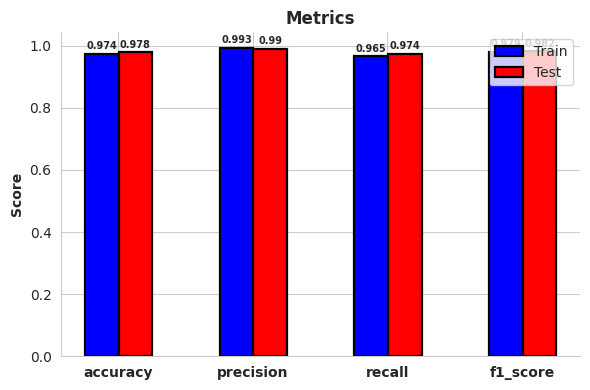

In [53]:
# select 4 metrics to compare:
# accuracy,precision, recall y f1-score

metrics_plot(metrics_train_lr, metrics_test_lr, ['accuracy','precision','recall','f1_score'])

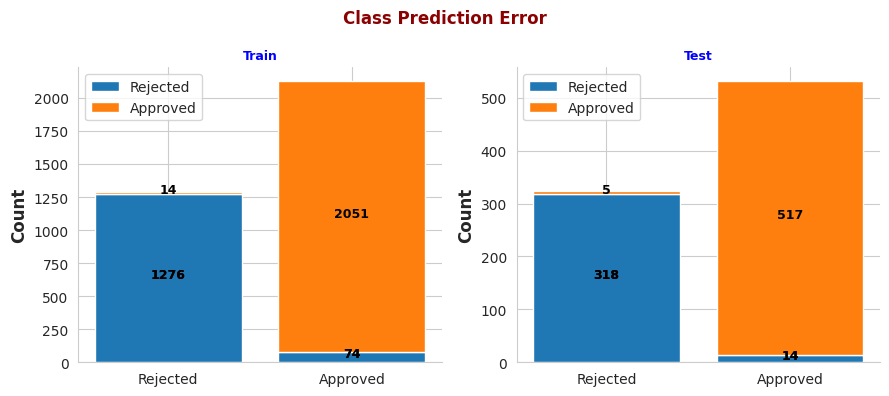

In [54]:
## Class prediction error
class_prediction_error(y_train, train_predictions[names[0]],y_test, test_predictions[names[0]],['Rejected','Approved'])

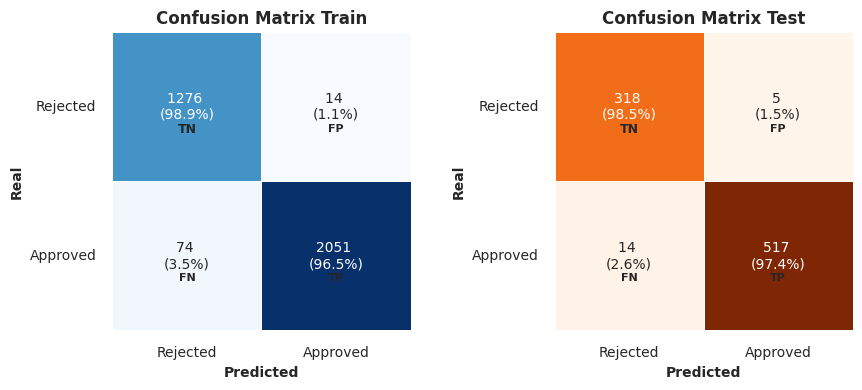

In [55]:
# Confusion Matrix
confusion_matrix_plot(y_train, train_predictions[names[0]],
                      y_test, test_predictions[names[0]])

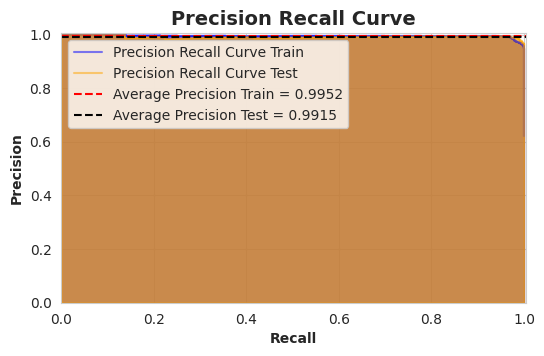

In [56]:
# Precision Recall
precision_recall_curve_plot(y_train, train_probabilities[names[0]],
                            y_test, test_probabilities[names[0]])

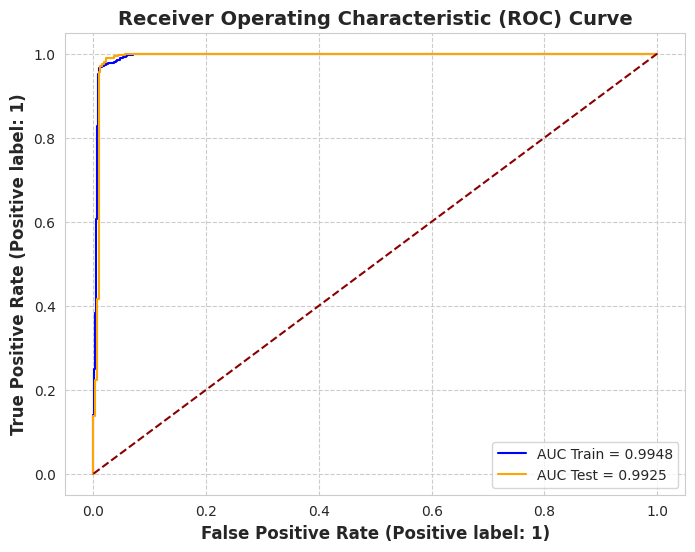

In [57]:
# ROC-AUC
roc_curve_plot(y_train, train_probabilities[names[0]],y_test, test_probabilities[names[0]])

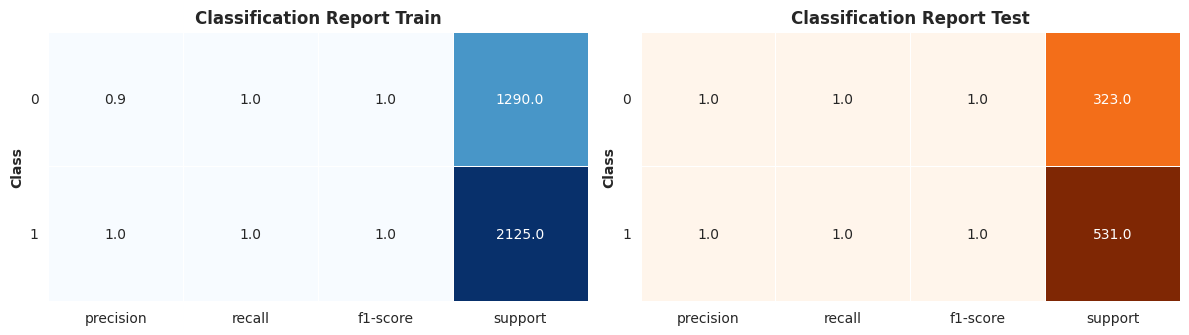

In [58]:
# Classification report
classification_report_plot(y_train, train_predictions[names[0]],
                           y_test, test_predictions[names[0]])

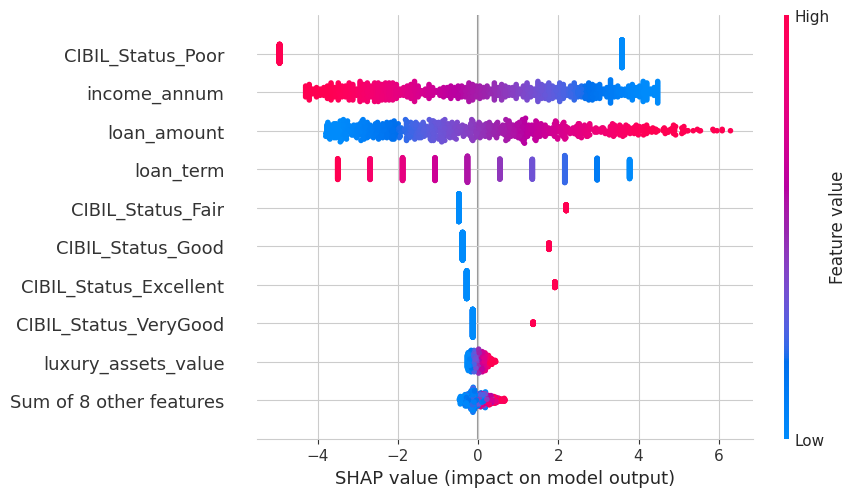

In [59]:
## Feature Importance
#==============================================================================
explainer_lr = shap.Explainer(list(trained_models.values())[0], X_train_prep_array, feature_names=X_train_prep.columns)
shap_values_lr = explainer_lr(X_test_prep_array)
shap.initjs()
shap.plots.beeswarm(shap_values_lr)

####Random Forest

In [60]:
metrics_train_rf = metrics_classification(y_train, train_predictions[names[1]],
                                          train_probabilities[names[1]])

metrics_test_rf = metrics_classification(y_test, test_predictions[names[1]],
                                         test_probabilities[names[1]])

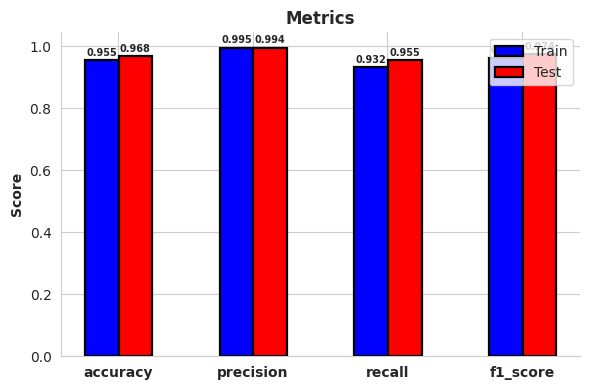

In [61]:
# select 4 metrics to compare:
# accuracy, precision, recall y f1-score

metrics_plot(metrics_train_rf, metrics_test_rf, ['accuracy','precision','recall','f1_score'])

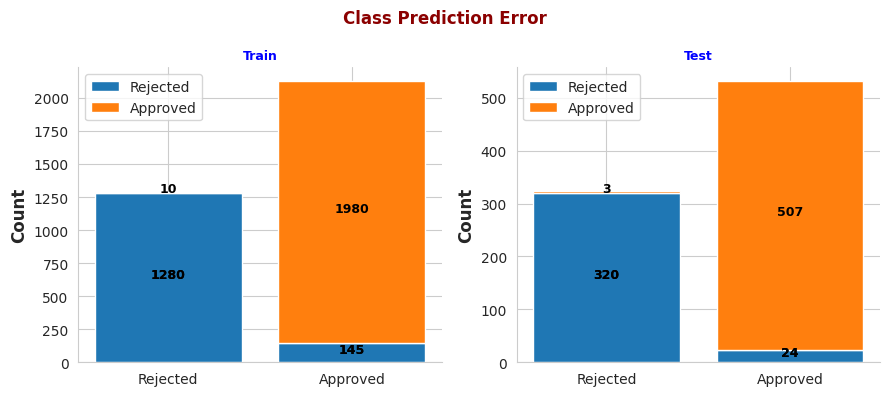

In [62]:
## Class prediction error
class_prediction_error(y_train, train_predictions[names[1]],y_test, test_predictions[names[1]],['Rejected','Approved'])

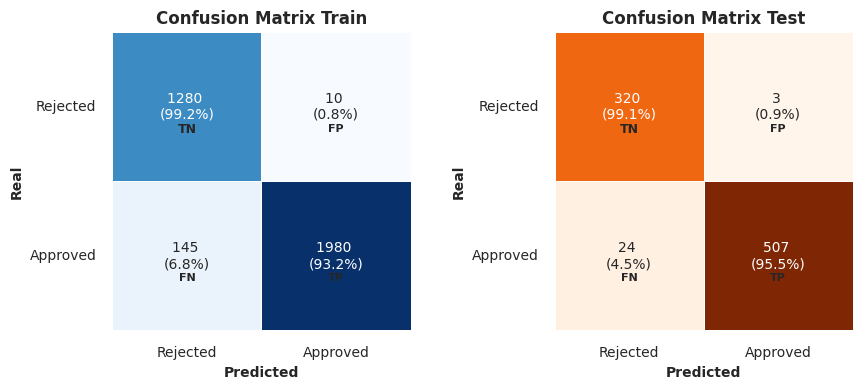

In [63]:
# Confusion Matrix
confusion_matrix_plot(y_train, train_predictions[names[1]],
                      y_test, test_predictions[names[1]])

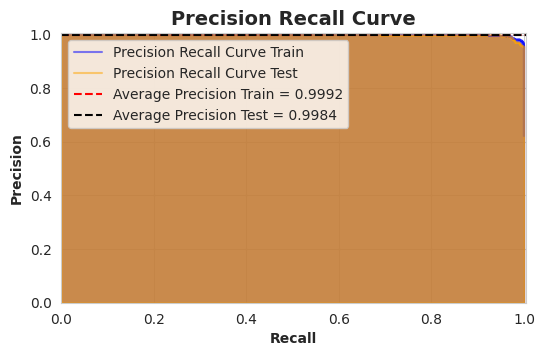

In [64]:
# Precision Recall
precision_recall_curve_plot(y_train, train_probabilities[names[1]],
                            y_test, test_probabilities[names[1]])

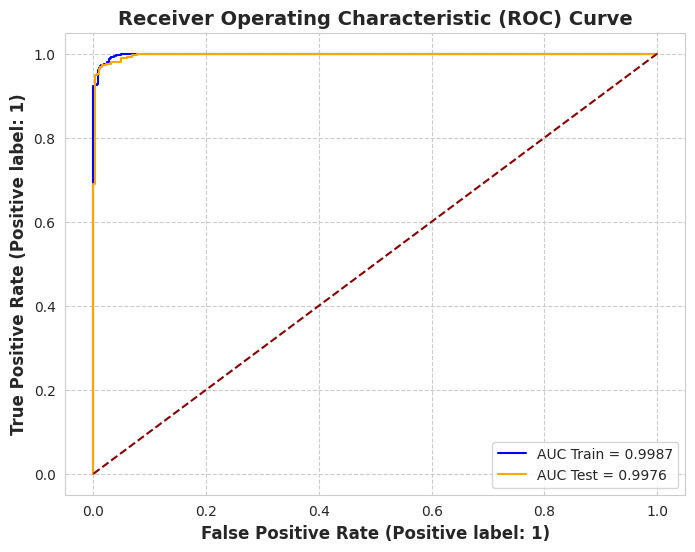

In [65]:
# ROC-AUC
roc_curve_plot(y_train, train_probabilities[names[1]],y_test, test_probabilities[names[1]])

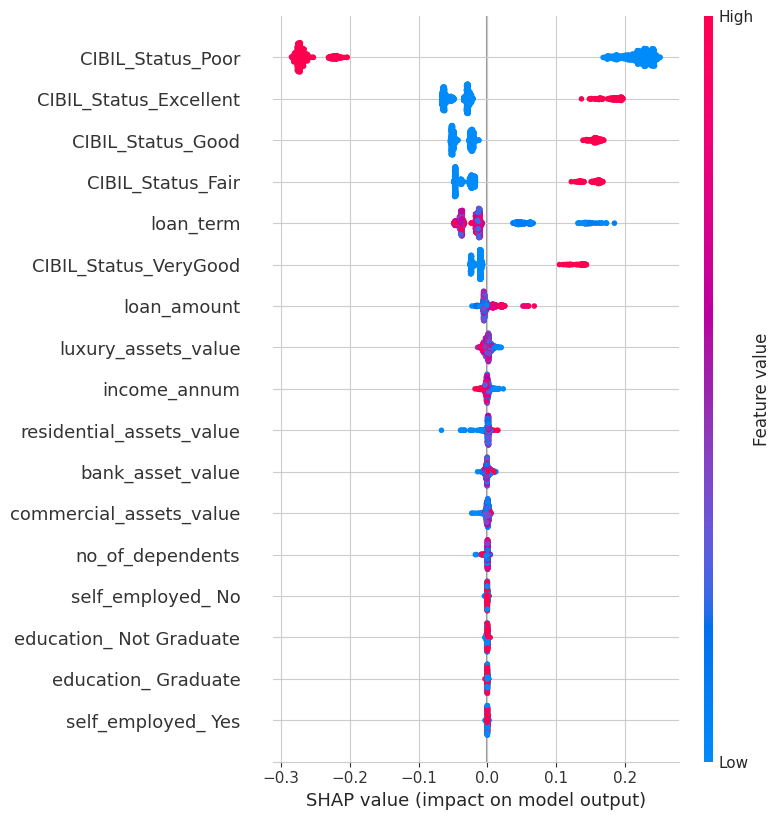

In [66]:
# TreeExplainer for the RandomForestClassifier model
explainer_rf = shap.TreeExplainer(list(trained_models.values())[1])

#  SHAP values
shap_values_rf = explainer_rf.shap_values(X_test_prep_array)

#  visualization
shap.initjs()

#  summary plot
shap.summary_plot(shap_values_rf[:, :, 1],  # Choose the SHAP values for the positive class
                   X_test_prep_array,
                   feature_names=X_train_prep.columns)

### Kmeans Clustering

In [67]:
from sklearn.cluster import KMeans

In [68]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', KMeans(n_clusters=2, random_state=42))
])

In [69]:
# Fit the KMeans model
pipeline.fit(X)

# Predict cluster labels
cluster_labels = pipeline.named_steps['clusterer'].labels_

# Add the cluster labels to the original data
data['Cluster'] = cluster_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


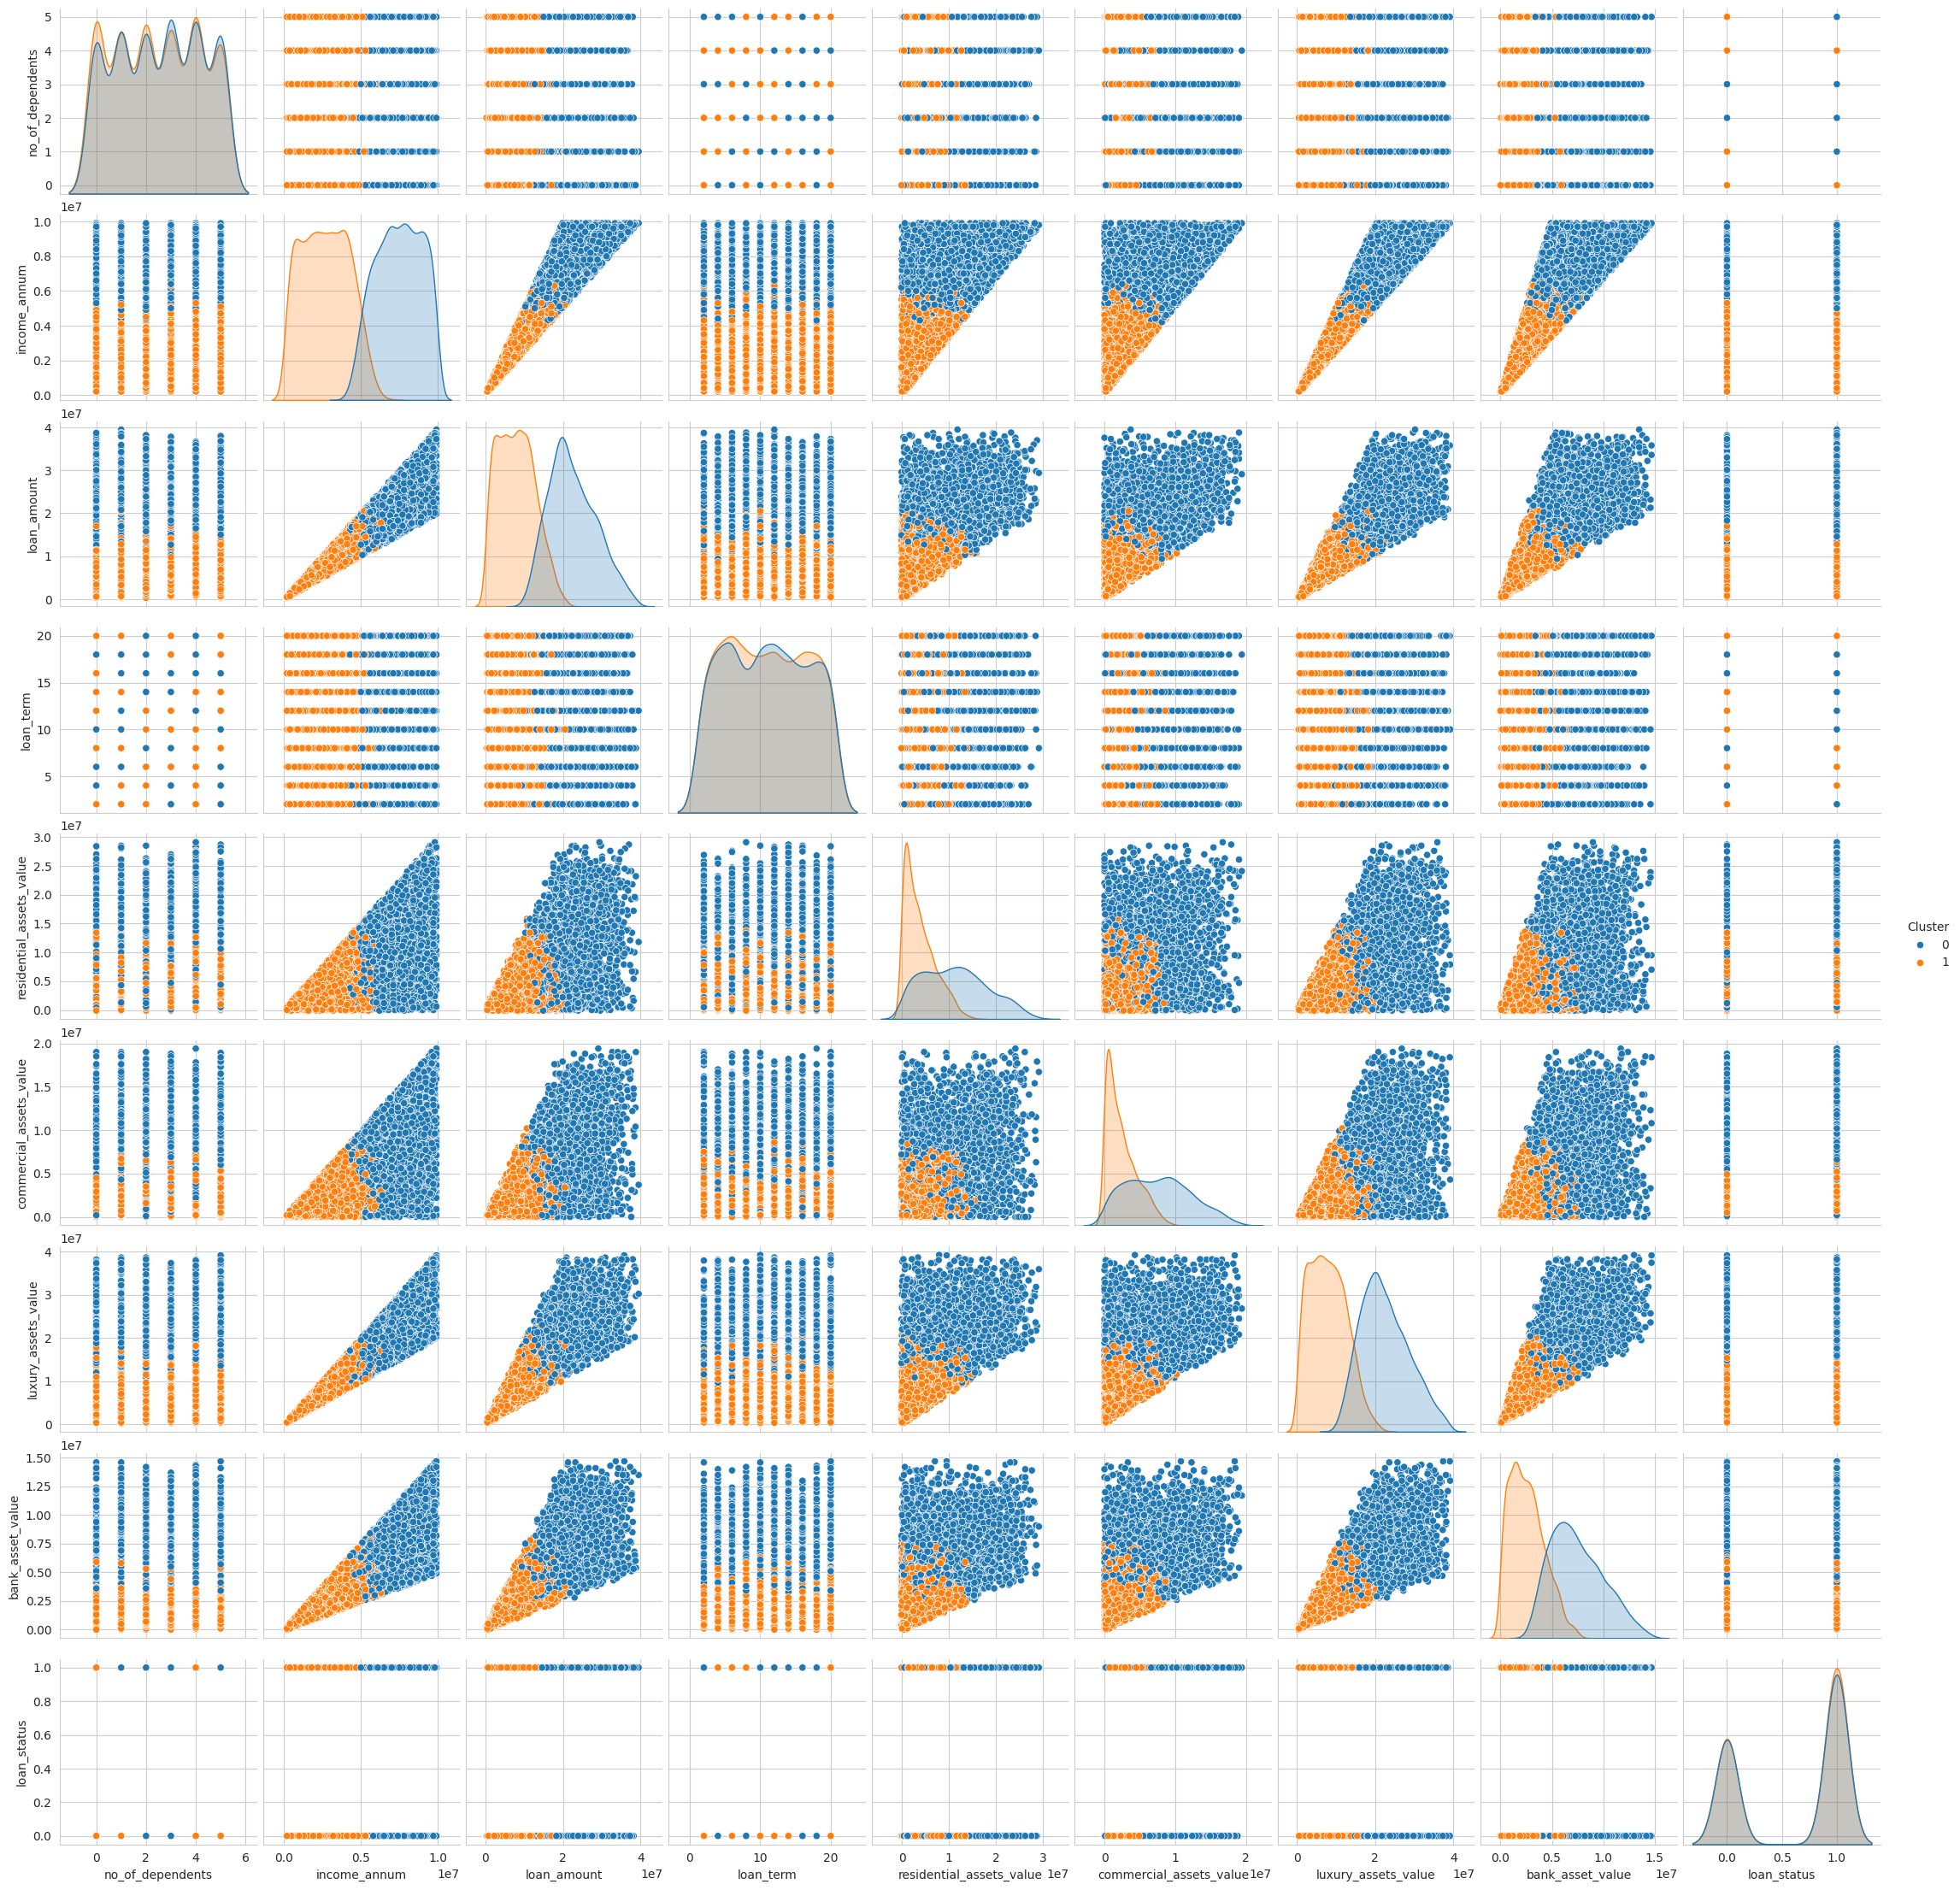

In [70]:
# Analyze the clusters
sns.pairplot(data, hue='Cluster', diag_kind='kde')
plt.show()

In [72]:
# Analyze cluster vs loan approval
print(data.groupby('Cluster')['loan_status'].value_counts(normalize=True))

Cluster  loan_status
0        1              0.618732
         0              0.381268
1        1              0.625522
         0              0.374478
Name: proportion, dtype: float64
